# Querying for reduced data

This section shows how to programmatically query the database table that exposes the metadata of the reduced data.

The table is called ivoa.ObsCore and it is fully compliant to the so-called **ObsCore** Virtual Observatory standard: [Observation Data Model Core Components and its Implementation in the Table Access Protocol, Version 1.1](http://ivoa.net/documents/ObsCore/index.html), IVOA Recommandation 09 May 2017, Louys et al.

In the following you will learn how to:

1. [Query by identifier](#query_by_identifier)
1. [Query by coordinates (aka spatial queries)](#query_by_coordinates)
   1. [Cone search](#cone_search)
   1. Products' footprints containing a user-defined point
   1. Products' footprints intersecting a user-defined polygon

First of all, let's:
* import what is necessary
* define the ESO Tabular Access Protocol endpoint used to search through the reduced data
* instantiate the TAP service

In [2]:
import os 
import sys

import numpy as np

from astropy.visualization import astropy_mpl_style

from astropy import table
from astropy.coordinates import SkyCoord
from astropy.units import Quantity

from pyvo.dal import tap

import matplotlib.pyplot as plt
import pandas

ESO_TAP_OBS = "http://archive.eso.org/tap_obs"

tapobs = tap.TAPService(ESO_TAP_OBS)

## <a id='query_by_identifier'>1. Query by identifier</a>

Each file in the archive has been assigned a unique ESO identifier. For reduced products this is a 27-character name whose first 4 characters are 'ADP.' followed by a datetime string, up to the millisecond. Example: ADP.2013-12-10T16:12:17.697
<small>(That timestamp is **not** the datetime when the observation was taken, take it just as a synthetic string without any associated meaning)</small>

Completely equivalently, a Virtual Observatory identifier (colloquially called "ivorn") exists, and takes the form of constant string 'ivo://eso.org/ID?' prepended to the ESO identifier. Example: ivo://eso.org/ID?ADP.2013-12-10T16:12:17.697

The same query can be expressed using either the ESO or the VO identifier; the ESO identifier is stored in the column 'dp_id', while the ivorn is in the ObsCore standard column 'obs_publisher_did'. Let's start with the standard query: 

In [3]:
dp_id = 'ADP.2013-12-10T16:12:17.697'
ivorn = 'ivo://eso.org/ID?' + dp_id

query = """SELECT *
FROM ivoa.ObsCore
WHERE obs_publisher_did = '%s'""" % (ivorn)

print(query)

SELECT *
FROM ivoa.ObsCore
WHERE obs_publisher_did = 'ivo://eso.org/ID?ADP.2013-12-10T16:12:17.697'


**Send the ADQL query to the ESO TAP service**

Beware: the next cell could return some warnings about wrong UCDs; that simply means that you have not yet updated to the latest version of astropy. Anyways, those warnings are not important, and you can continue disregarding them.

The search return the table of results (res).

In [4]:
res = tapobs.search(query=query, maxrec=1000)

print(res)

<Table length=1>
abmaglim access_estsize ... t_xel target_name
             kbyte      ...                  
float64      int64      ... int64    object  
-------- -------------- ... ----- -----------
      --           1186 ...    --  J0001+0307


Given the 'SELECT *', the result set contains all the ObsCore columns.
The ESO ObsCore table contains 41 columns of the ObsCore standard, plus 9 ESO-specific columns, which are:
* abmaglim (available only for images, catalogtiles, and cubes)
* gal_lat
* gal_lon
* multi_ob
* n_obs
* obstech
* p3orig
* publication_date
* snr (available only for spectra)

The following shows all the returned columns and their values.

In [5]:
for colname in res.to_table().colnames:
    print("{:20s} \t = \t {}".format(colname, res[colname][0]))

abmaglim             	 = 	 0.0
access_estsize       	 = 	 1186
access_format        	 = 	 b'application/x-votable+xml;content=datalink'
access_url           	 = 	 b'http://archive.eso.org/datalink/links?ID=ivo://eso.org/ID?ADP.2013-12-10T16:12:17.697'
bib_reference        	 = 	 b''
calib_level          	 = 	 2
dataproduct_subtype  	 = 	 b''
dataproduct_type     	 = 	 b'spectrum'
dp_id                	 = 	 b'ADP.2013-12-10T16:12:17.697'
em_max               	 = 	 4.56293e-07
em_min               	 = 	 3.2819e-07
em_res_power         	 = 	 39090.0
em_xel               	 = 	 46961
facility_name        	 = 	 b'ESO-VLT-U2'
filter               	 = 	 b''
gal_lat              	 = 	 -57.421596
gal_lon              	 = 	 99.219121
instrument_name      	 = 	 b'UVES'
multi_ob             	 = 	 b'S'
n_obs                	 = 	 1
o_calib_status       	 = 	 b'absolute'
o_ucd                	 = 	 b''
obs_collection       	 = 	 b'UVES'
obs_creator_did      	 = 	 b'ivo://eso.org/origfile?UV_SFLX_981908_

## <a id='query_by_coordinates'>2. Query by coordinates (aka spatial queries)</a>

You are interested in a positional query, as you want to find products around a certain position in the sky. There are multple ways one can pose such question; it all depends on the use case at hand and which data you are looking for.

On one side, the data...

The reduced data are spatially characterised by their footprint (column: s_region).
In the example above, the footprint of the source table is described by a polygon.
The types of footprins in the ESO archive are:
* a point (this is the case for spectra and visibilities)
* a circle (this is the case for the majority of ALMA data)
* a polygon (e.g. for tile images, catalog tiles, cubes)
* a union of polygons (e.g. uncombined images of a multichip camera, and relative source tables) 

On the other side, your use case...

You might want to apply different criteria, e.g.: 
* give me any spectra within N arcsec from a certain point,
    * this is the typical cone search
* give me any product close to a certain point,
    * no special requirements, just investigating
* give me any product that actually cover a certain point,
    * e.g. to find progenitors of supernovae
* give me any product covering different parts an extended region,
    * e.g. to map the Orion nebula


### <a id='cone_seach'>2.A- Cone search</a>

You are looking for products whose footprint is point-like (either spectra or visibilities, at this moment in time). 

Let's assume you want to find any spectra in a circle around your favourite object.

Either you know the equatorial coordinates of your object, or you rely onto a name resolver like SESAME. 

Let's search for spectra taken within a diameter of 5 arcmin around NGC 4666.
Let's rely on SESAME (CDS).

In [6]:
# Defining position via SESAME name resolver, and search radius
target = "NGC 4666"
sr = 2.5/60. # search radius of 2.5 arcmin, always expressed in degrees

pos = SkyCoord.from_name(target)
print("SESAME coordinates for %s: %s (truncated to millidegrees)\n" % (target, pos.to_string()))

query = """SELECT *
FROM ivoa.ObsCore
WHERE dataproduct_type='spectrum'
AND contains(s_region, circle('', %f, %f, %f))=1
ORDER BY t_min""" % (pos.ra.degree , pos.dec.degree, sr)

print(query)

SESAME coordinates for NGC 4666: 191.286 -0.461911 (truncated to millidegrees)

SELECT *
FROM ivoa.ObsCore
WHERE dataproduct_type='spectrum'
AND contains(s_region, circle('', 191.286150, -0.461911, 0.041667))=1
ORDER BY t_min


In [18]:
res = tapobs.search(query=query, maxrec=1000)
print("Num matching datasets: %d" % (len(res)))
print(res)

Num matching datasets: 50
<Table length=50>
abmaglim access_estsize ... t_xel target_name
             kbyte      ...                  
float64      int64      ... int64    object  
-------- -------------- ... ----- -----------
      --           3755 ...    -- SN_Ia_epI_a
      --           2718 ...    -- SN_Ia_epI_a
      --             46 ...    -- ASASSN-14lp
      --             46 ...    -- ASASSN-14lp
      --           3755 ...    -- SN_Ia_epI_a
      --           2718 ...    -- SN_Ia_epI_a
      --           3755 ...    -- SN_Ia_epI_a
      --           2718 ...    -- SN_Ia_epI_a
      --           3755 ...    -- SN_Ia_epI_b
     ...            ... ...   ...         ...
      --           2707 ...    -- ASASSN-14lp
      --           2707 ...    -- ASASSN-14lp
      --           3755 ...    -- ASASSN-14lp
      --           2707 ...    -- ASASSN-14lp
      --           3755 ...    -- ASASSN-14lp
      --             46 ...    -- ASASSN-14lp
      --             46 ...    -- AS

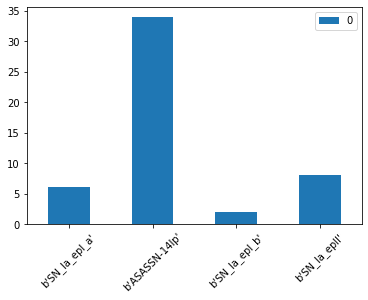

In [17]:
from collections import Counter
dp_types = res['target_name']
dp_types_counts = Counter(dp_types)
df = pandas.DataFrame.from_dict(dp_types_counts, orient='index')
df.plot(kind='bar', rot=45)

In [20]:
import ipyaladin